In [13]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

In [14]:
import os
print(os.getcwd())


c:\Users\dprih\OneDrive\Dokumen\ITS\ITS Semester 6\Capstone-Bangkit-ML\forecasting\model


In [15]:
# Memuat data
data = pd.read_csv("C:\\Users\\dprih\\OneDrive\\Dokumen\\ITS\\ITS Semester 6\\Capstone-Bangkit-ML\\scrap-data-new\\new-scrap-mean\\tomat_mean.csv")
data['tanggal'] = pd.to_datetime(data['tanggal'])
data.set_index('tanggal', inplace=True)
data

,no,hrg
tanggal,,
2023-01-01,0,10550.973684
2023-01-02,1,10529.210526
2023-01-03,2,11508.605263
2023-01-04,3,10411.894737
2023-01-05,4,10145.631579
...,...,...
2024-06-11,527,12668.368421
2024-06-12,528,12339.210526
2024-06-13,529,12072.763158


In [16]:
#Drop the no 
data = data.drop(columns=['no'])
data

,hrg
tanggal,
2023-01-01,10550.973684
2023-01-02,10529.210526
2023-01-03,11508.605263
2023-01-04,10411.894737
2023-01-05,10145.631579
...,...
2024-06-11,12668.368421
2024-06-12,12339.210526
2024-06-13,12072.763158


In [17]:
# Menormalisasi data harga
scaler = MinMaxScaler(feature_range=(0, 1))
data['hrg'] = scaler.fit_transform(data['hrg'].values.reshape(-1,1))

In [18]:
# Membuat dataset untuk LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [19]:
# Parameter
time_step = 10

In [20]:
# Membagi data menjadi train dan test
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:len(data)]

In [21]:
# Membuat dataset untuk train dan test
trainX, trainY = create_dataset(train.values, time_step)
testX, testY = create_dataset(test.values, time_step)

In [22]:
# Mengubah input menjadi [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

In [23]:
# Membangun model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Menampilkan ringkasan model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9), loss=tf.keras.losses.Huber())

# Melatih model
model.fit(trainX, trainY, batch_size=1, epochs=20)

Epoch 1/20
414/414 [==============================] - 8s 9ms/step - loss: 0.0043
Epoch 2/20
414/414 [==============================] - 3s 8ms/step - loss: 7.4420e-04
Epoch 3/20
414/414 [==============================] - 3s 7ms/step - loss: 6.9881e-04
Epoch 4/20
414/414 [==============================] - 3s 8ms/step - loss: 6.9334e-04
Epoch 5/20
414/414 [==============================] - 3s 7ms/step - loss: 6.7236e-04
Epoch 6/20
414/414 [==============================] - 3s 7ms/step - loss: 6.2700e-04
Epoch 7/20
414/414 [==============================] - 5s 11ms/step - loss: 6.6138e-04
Epoch 8/20
414/414 [==============================] - 4s 9ms/step - loss: 6.3768e-04
Epoch 9/20
414/414 [==============================] - 3s 7ms/step - loss: 6.8907e-04
Epoch 10/20
414/414 [==============================] - 4s 10ms/step - loss: 7.0411e-04
Epoch 11/20
414/414 [==============================] - 4s 9ms/step - loss: 6.8173e-04
Epoch 12/20
414/414 [==============================] - 4s 9ms/ste

In [25]:
# Melakukan prediksi
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

3/3 [==============================] - 0s 4ms/step


In [26]:
# Mengembalikan harga ke skala semula
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

In [27]:
# Menghitung MAPE untuk train dan test
mape_train = mean_absolute_percentage_error(trainY, train_predict) * 100
mape_test = mean_absolute_percentage_error(testY, test_predict) * 100

print(f"MAPE Train: {mape_train}%")
print(f"MAPE Test: {mape_test}%")

MAPE Train: 4.6179774422471915%
MAPE Test: 9.341299149011943%


In [28]:

# Membuat dataframe untuk hasil prediksi train
train_predict_df = pd.DataFrame({
    'tanggal': data.index[time_step:len(train_predict) + time_step],
    'harga_asli': trainY.flatten(),
    'harga_prediksi': train_predict.flatten()
})
train_predict_df.set_index('tanggal', inplace=True)

# Membuat dataframe untuk hasil prediksi test
test_predict_df = pd.DataFrame({
    'tanggal': data.index[len(train_predict) + (time_step * 2) + 1:len(data) - 1],
    'harga_asli': testY.flatten(),
    'harga_prediksi': test_predict.flatten()
})
test_predict_df.set_index('tanggal', inplace=True)

# Menampilkan hasil prediksi train
print("Hasil Prediksi Train:")
print(train_predict_df.head())

# Menampilkan hasil prediksi test
print("Hasil Prediksi Test:")
print(test_predict_df.head())

Hasil Prediksi Train:
             harga_asli  harga_prediksi
tanggal                                
2023-01-11  8694.605263    10113.320312
2023-01-12  8407.394737     9891.625000
2023-01-13  8207.815789     9646.195312
2023-01-14  8105.842105     9340.957031
2023-01-15  7975.105263     9095.731445
Hasil Prediksi Test:
              harga_asli  harga_prediksi
tanggal                                 
2024-03-11  16926.421053    14969.616211
2024-03-12  17345.000000    15269.985352
2024-03-13  18255.973684    15627.849609
2024-03-14  19442.342105    16057.528320
2024-03-15  20625.026316    16576.613281


In [29]:
# Prediksi harga masa depan
future_steps = 30  # jumlah langkah ke depan yang ingin diprediksi
last_sequence = data.values[-time_step:]  # ambil urutan terakhir dari data

future_predictions = []

for _ in range(future_steps):
    # Ubah bentuk input menjadi [samples, time steps, features]
    input_sequence = last_sequence.reshape((1, time_step, 1))
    next_prediction = model.predict(input_sequence)
    future_predictions.append(next_prediction[0, 0])
    
    # Perbarui urutan terakhir dengan menggeser ke kiri dan menambahkan prediksi terbaru
    last_sequence = np.append(last_sequence[1:], next_prediction)[-time_step:]

# Mengembalikan harga ke skala semula untuk prediksi masa depan
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Membuat tanggal untuk prediksi masa depan
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, inclusive='right')

# Membuat dataframe untuk hasil prediksi masa depan
future_predict_df = pd.DataFrame({
    'tanggal': future_dates,
    'harga_prediksi': future_predictions.flatten()
})
future_predict_df.set_index('tanggal', inplace=True)

# Menampilkan hasil prediksi masa depan
print("Hasil Prediksi Masa Depan:")
print(future_predict_df.head())

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step
Hasil Prediksi Masa Depan:
            harga_prediksi
tanggal                   
2024-06-16    13106.423828
2024-06-17    12884.116211
2024-06-18    12755.123047
2024-06-19    12680.709961
2024-06-20    12634.948242


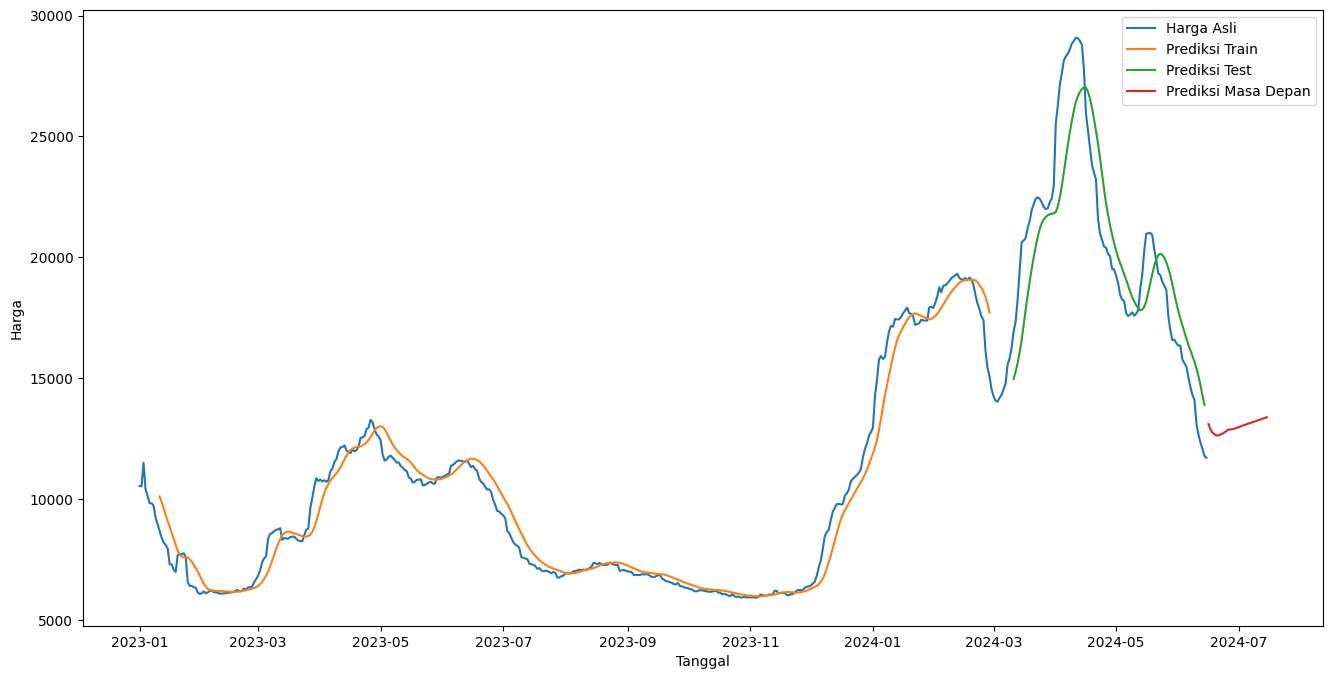

In [30]:
# Visualisasi hasil
plt.figure(figsize=(16,8))
plt.plot(data.index, scaler.inverse_transform(data['hrg'].values.reshape(-1, 1)), label='Harga Asli')
plt.plot(data.index[time_step:len(train_predict) + time_step], train_predict, label='Prediksi Train')
plt.plot(data.index[len(train_predict) + (time_step * 2) + 1:len(data) - 1], test_predict, label='Prediksi Test')
plt.plot(future_predict_df.index, future_predict_df['harga_prediksi'], label='Prediksi Masa Depan')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.show()

## Saving the Model in Different Formats:
- Pickle

In [31]:
# import pickle

# # Save the model using Pickle
# with open('tomat_forecasting.pkl', 'wb') as file:
#     pickle.dump(model, file)

# # Load the model using Pickle
# with open('tomat_forecasting.pkl', 'rb') as file:
#     loaded_model_pickle = pickle.load(file)

- H5

In [32]:
# Save the model using H5 format
model.save('tomat_forecasting.h5')

# Load the model using H5 format
from tensorflow.keras.models import load_model
loaded_model_h5 = load_model('tomat_forecasting.h5')

- TensorFlow Saved Model

In [33]:
# # Save the model using TensorFlow SavedModel format
# model.save('saved_model/tomat_forecasting')

# # Load the model using TensorFlow SavedModel format
# loaded_model_saved = tf.keras.models.load_model('saved_model/tomat_forecasting')

- TensorFlow Lite

In [34]:
# # Convert the model to TensorFlow Lite format
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the TensorFlow Lite model
# with open('tomat_forecasting.tflite', 'wb') as file:
#     file.write(tflite_model)

# # Load the TensorFlow Lite model (for inference, not training)
# interpreter = tf.lite.Interpreter(model_path='tomat_forecasting.tflite')
# interpreter.allocate_tensors()

# # Getting input and output tensors
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()